In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from yaml import safe_load

pd.set_option("display.max_rows", 100)

In [2]:
path_to_binary_cat_multi_results = "/dccstor/bmfm-targets/text_models/manuscript/performance/results_binary_categorical_multi_long_format.csv"
path_to_derived_results = "/dccstor/bmfm-targets/text_models/manuscript/performance/results_derived_binary_long_format.csv"
path_to_task_family_dict = (
    "/dccstor/bmfm-targets/text_models/manuscript/task_family_dict.yaml"
)

In [3]:
results_df = pd.read_csv(path_to_binary_cat_multi_results)
derived_df = pd.read_csv(path_to_derived_results)

results_df = results_df[results_df["model_name"] != "GEARS"]
derived_df = derived_df[derived_df["model_name"] != "GEARS"]

with open(path_to_task_family_dict) as f:
    task_to_family_dict = safe_load(f)

In [4]:
def mean_std_string(vals):
    mean_val = np.mean(vals)
    if np.isnan(mean_val):
        return "-"
    elif mean_val > 1:
        f"{np.mean(vals):.0f} ({np.std(vals):.0f})"
    else:
        return f"{np.mean(vals):.2f} ({np.std(vals):.2f})"

In [5]:
def sort_task_by_family_order(data, order, task_family_dict):
    data["task_names"] = list(data.index)
    data["family"] = data["task_names"].apply(lambda x: task_family_dict[x])
    data["task_names"] = data["task_names"].str.capitalize()
    family_index = [" ", " ", " ", " "]
    new_rows_df = pd.DataFrame(None, columns=data.columns, index=family_index)
    new_rows_df["family"] = data["family"].unique()
    new_rows_df["task_names"] = " "
    data = pd.concat([data, new_rows_df])
    data["family"] = pd.Categorical(data["family"], categories=order, ordered=True)
    data = data.sort_values(by=["family", "task_names"])
    data = data.drop(["task_names", "family"], axis=1)
    return data

In [6]:
def plot_heatmap(
    data,
    row_index,
    metric,
    metric_label,
    metric_limits,
    agg_function,
    row_order,
    col_order,
    figure_size,
    out_file_name,
    annotation_function=False,
    save=False,
    task_to_family_dict_for_sorting=False,
):
    mean_values = data.loc[data["metric"] == metric, :].pivot_table(
        values="score",
        index=row_index,
        columns=["Model"],
        aggfunc=agg_function,
        sort=False,
    )
    annotations = mean_values.applymap(lambda x: f"{x:.2f}")
    if annotation_function:
        annotations = data.loc[data["metric"] == metric, :].pivot_table(
            values="score",
            index=["task_group"],
            columns=["Model"],
            aggfunc=annotation_function,
            sort=False,
        )
    if task_to_family_dict_for_sorting:
        mean_values = sort_task_by_family_order(
            mean_values, row_order, task_to_family_dict_for_sorting
        )
        annotations = sort_task_by_family_order(
            annotations, row_order, task_to_family_dict_for_sorting
        )

    if row_index == "task_group":
        mean_values = mean_values.loc[row_order, col_order]
        annotations = annotations.loc[row_order, col_order]

    fig, ax = plt.subplots(figsize=figure_size)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    ax = sns.heatmap(
        mean_values.loc[:, col_order],
        yticklabels=True,
        vmin=metric_limits[0],
        vmax=metric_limits[1],
        cmap="Blues",
        annot=annotations.loc[:, col_order],
        fmt="",
        cbar_kws={"label": metric_label},
        ax=ax,
        cbar_ax=cax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel("Task Family")
    if task_to_family_dict_for_sorting:
        id = 0
        fam_id = 0
        for label, y_label in zip(ax.yaxis.get_ticklabels(), mean_values.index):
            if y_label == " ":
                label.set_visible(False)
                ax.yaxis.get_major_ticks()[id].set_visible(False)
                ax.text(
                    4.5,
                    id + 1,
                    row_order[fam_id],
                    fontsize=10,
                    ha="center",
                    va="bottom",
                )
                fam_id += 1
            id += 1
    if save:
        fig.savefig(out_file_name, dpi=300, bbox_inches="tight")

In [7]:
model_order = [
    "MTEB-L",
    "MTEB-S",
    "MPNet",
    "Bag of Words",
    "cellPLM",
    "Geneformer",
    "ScGPT",
    "Gene2vec",
]

family_order = [
    "Genomic properties",
    "Regulatory functions",
    "Biological processes",
    "Localization",
]

metric = "roc_auc"
metric_label = "Mean AUC (std)"
results_df["Model"] = results_df["Model"].replace(
    {"MTEB-1B": "MTEB-S", "MTEB-7B": "MTEB-L"}
)
derived_df["Model"] = derived_df["Model"].replace(
    {"MTEB-1B": "MTEB-S", "MTEB-7B": "MTEB-L"}
)

In [8]:
derived_df[["task_name", "task_group", "task_type"]].drop_duplicates().groupby(
    ["task_type"]
)["task_group"].value_counts()

task_type    task_group          
derived bin  Biological processes    4
             Genomic properties      2
             Localization            1
Name: count, dtype: int64

In [9]:
results_df[["task_name", "task_group", "task_type"]].drop_duplicates().groupby(
    ["task_type"]
)["task_group"].value_counts()

task_type    task_group          
binary       Regulatory functions     5
             Biological processes     3
             Genomic properties       3
category     Localization            22
             Biological processes    21
             Genomic properties       1
multi label  Biological processes     4
             Genomic properties       2
             Localization             1
Name: count, dtype: int64

In [10]:
model_all_tab_name = results_df.loc[results_df["metric"] == metric, :].pivot_table(
    values="score",
    columns=[
        "task_group",
    ],
    index=["task_type", "Model family", "Model"],
    aggfunc=mean_std_string,
    sort=False,
)

/tmp/ipykernel_462485/2832445688.py:16: FutureWarning: The provided callable <function mean at 0x7f6c82dfa9e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mean_values = data.loc[data["metric"] == metric, :].pivot_table(
/tmp/ipykernel_462485/2832445688.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = mean_values.applymap(lambda x: f"{x:.2f}")


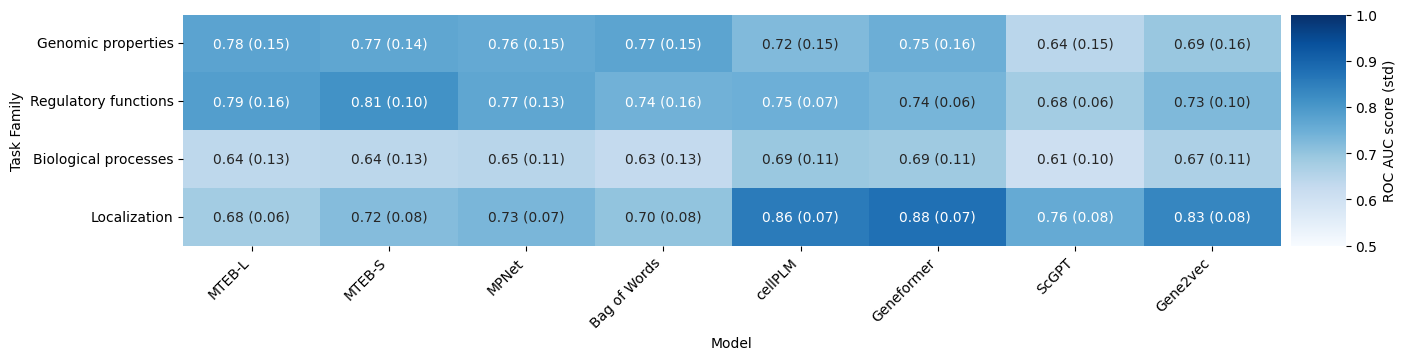

In [11]:
metric = "roc_auc"
metric_label = "ROC AUC score (std)"
plot_heatmap(
    data=results_df,
    row_index="task_group",
    metric=metric,
    metric_label=metric_label,
    metric_limits=[0.5, 1],
    agg_function=np.mean,
    row_order=family_order,
    col_order=model_order,
    out_file_name="performance_family_model.pdf",
    figure_size=(15, 3),
    save=True,
    annotation_function=mean_std_string,
)

/tmp/ipykernel_462485/2832445688.py:16: FutureWarning: The provided callable <function mean at 0x7f6c82dfa9e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  mean_values = data.loc[data["metric"] == metric, :].pivot_table(
/tmp/ipykernel_462485/2832445688.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = mean_values.applymap(lambda x: f"{x:.2f}")


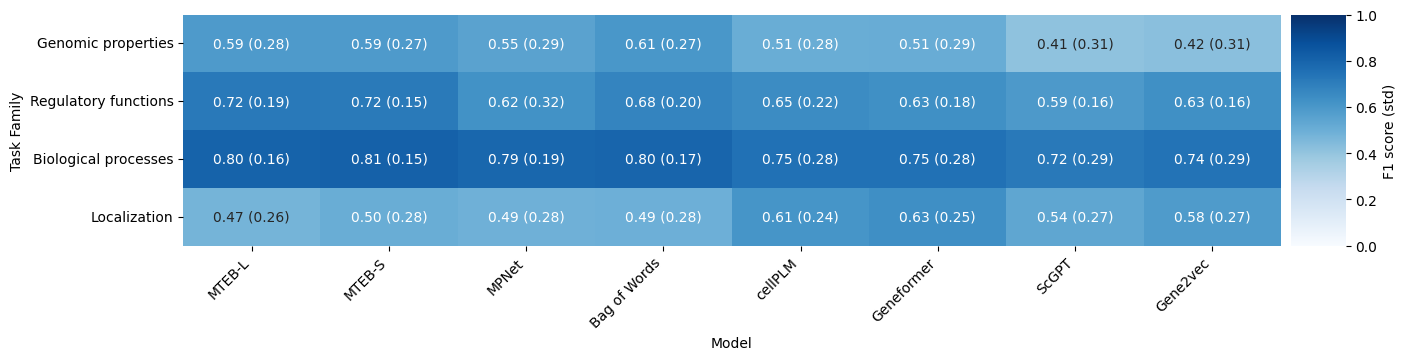

In [12]:
metric = "f1"
metric_label = "F1 score (std)"
plot_heatmap(
    data=results_df,
    row_index="task_group",
    metric=metric,
    metric_label=metric_label,
    metric_limits=[0, 1],
    agg_function=np.mean,
    row_order=family_order,
    col_order=model_order,
    out_file_name="performance_family_model_f1.pdf",
    figure_size=(15, 3),
    save=True,
    annotation_function=mean_std_string,
)

/tmp/ipykernel_462485/2832445688.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = mean_values.applymap(lambda x: f"{x:.2f}")
/tmp/ipykernel_462485/877983692.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, new_rows_df])


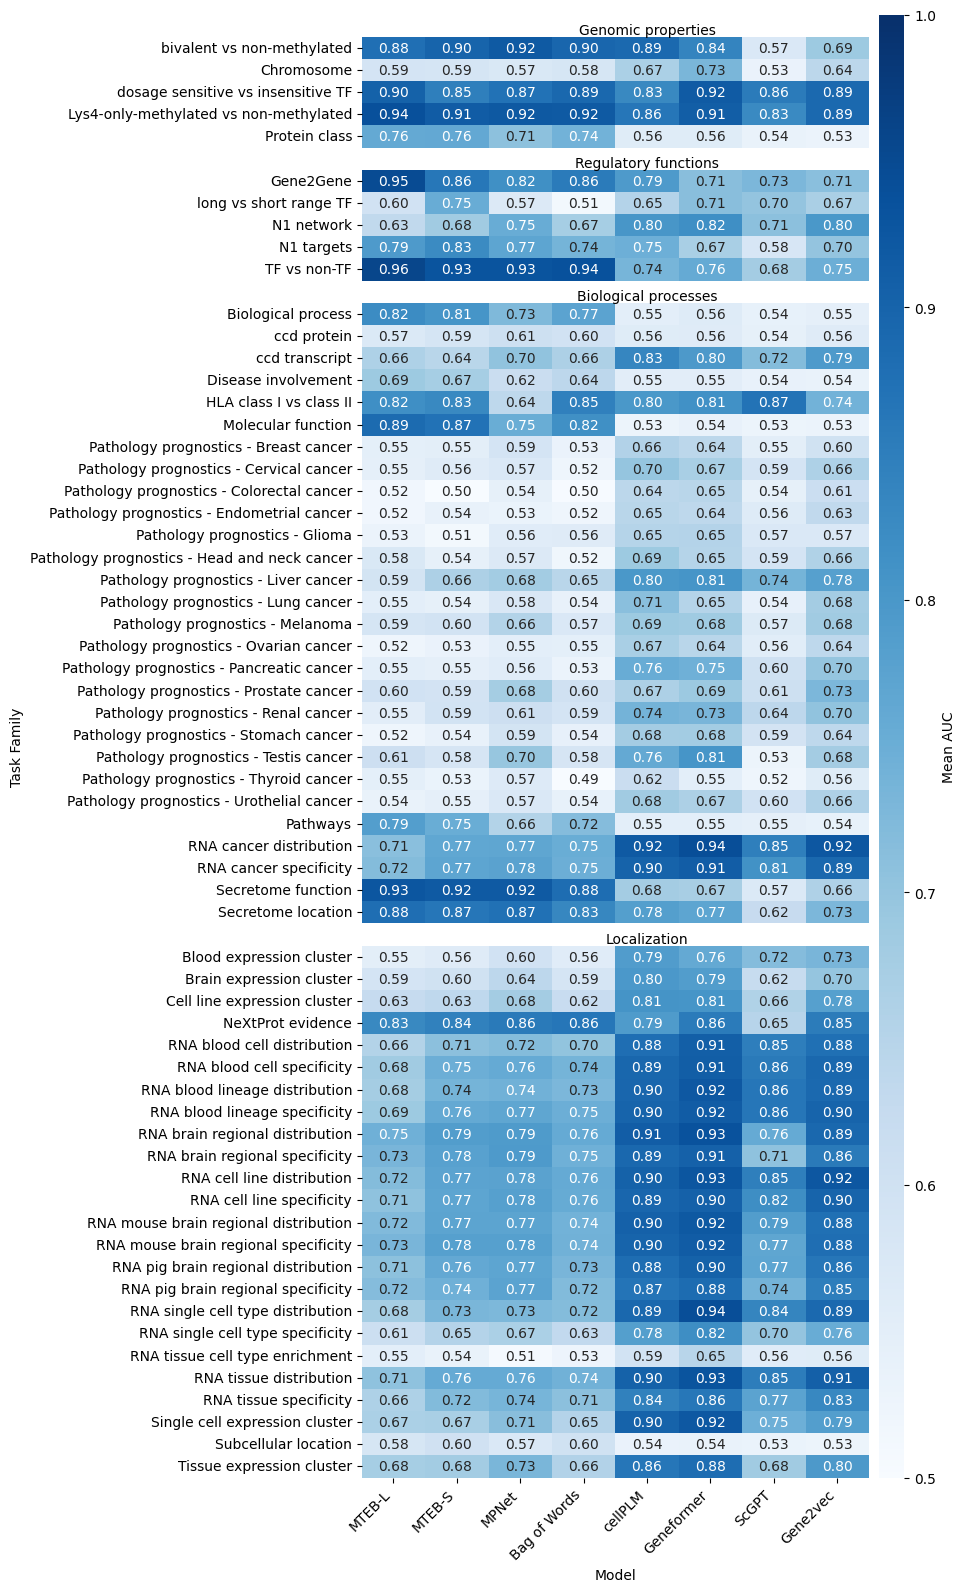

In [13]:
metric = "roc_auc"
metric_label = "Mean AUC"
plot_heatmap(
    data=results_df,
    row_index="task_name",
    metric=metric,
    metric_label=metric_label,
    metric_limits=[0.5, 1],
    agg_function="mean",
    row_order=family_order,
    col_order=model_order,
    figure_size=(7, 19),
    out_file_name="performance_task_model.pdf",
    annotation_function=None,
    save=True,
    task_to_family_dict_for_sorting=task_to_family_dict,
)

/tmp/ipykernel_462485/2832445688.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = mean_values.applymap(lambda x: f"{x:.2f}")


/tmp/ipykernel_462485/2832445688.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = mean_values.applymap(lambda x: f"{x:.2f}")
/tmp/ipykernel_462485/2832445688.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = mean_values.applymap(lambda x: f"{x:.2f}")
/tmp/ipykernel_462485/2832445688.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = mean_values.applymap(lambda x: f"{x:.2f}")
/tmp/ipykernel_462485/2832445688.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = mean_values.applymap(lambda x: f"{x:.2f}")
/tmp/ipykernel_462485/2832445688.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = mean_values.applymap(lambda x: f"{x:.2f}")
/tmp/ipykernel_462485/2832445688.py:23: FutureWarning: DataFrame.applymap has been deprecated. 

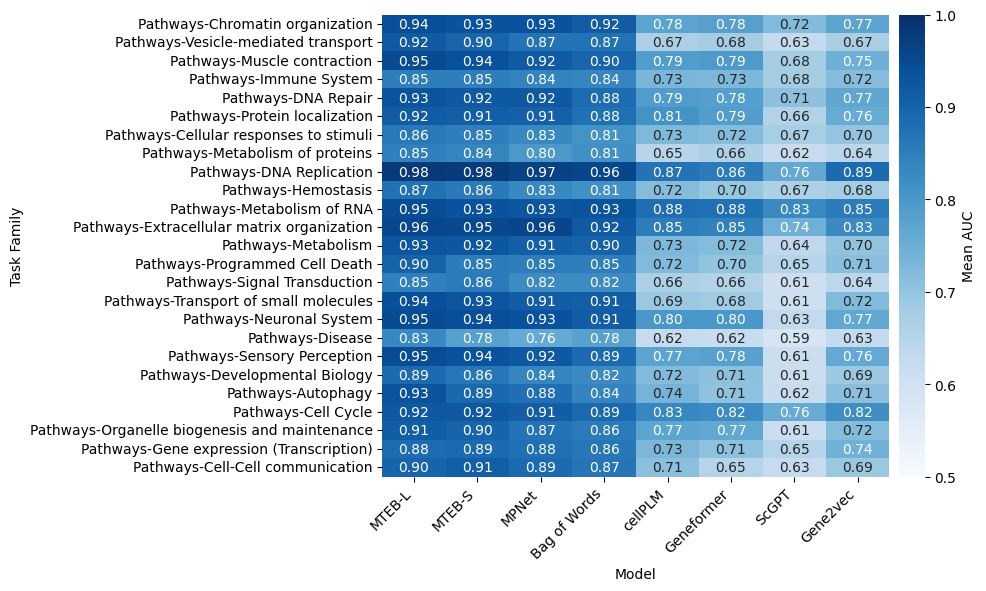

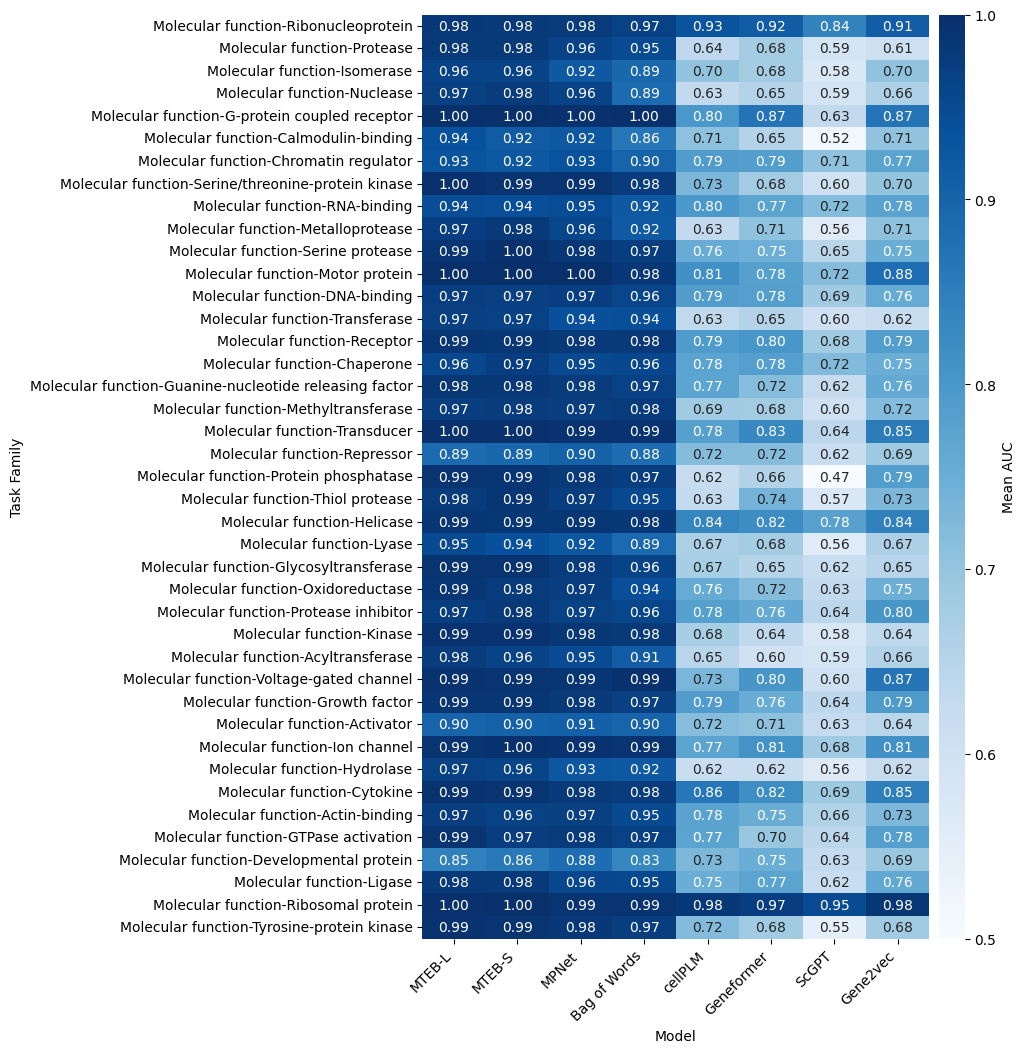

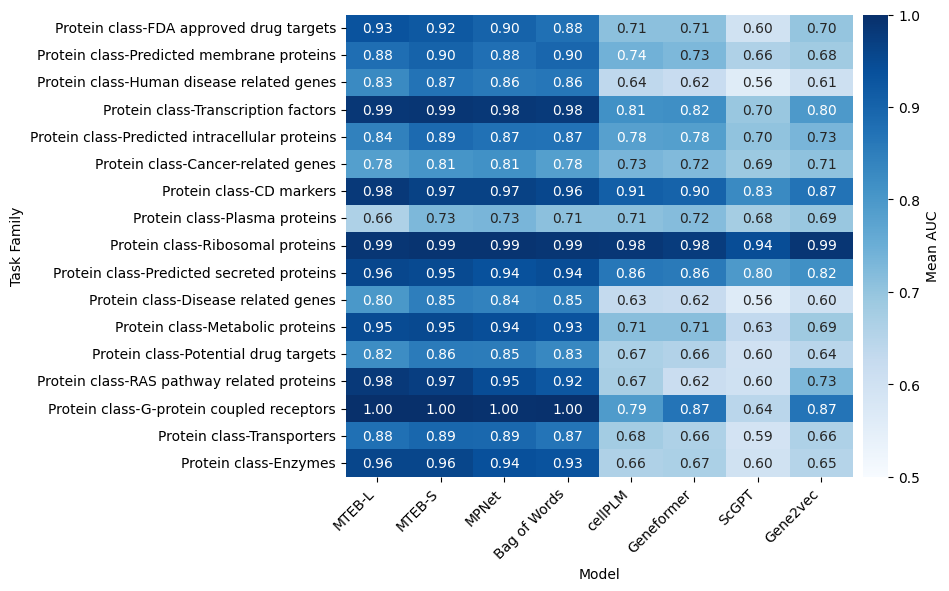

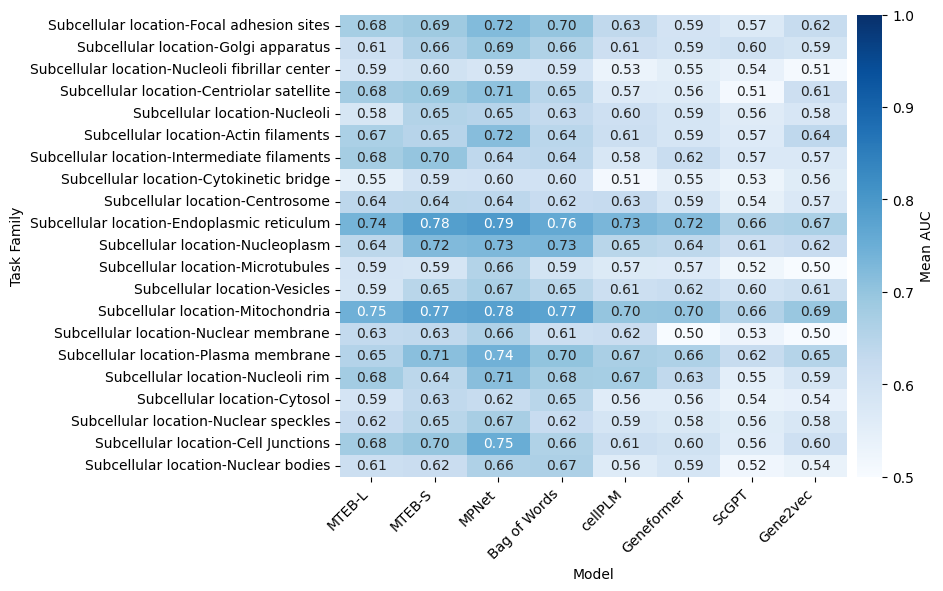

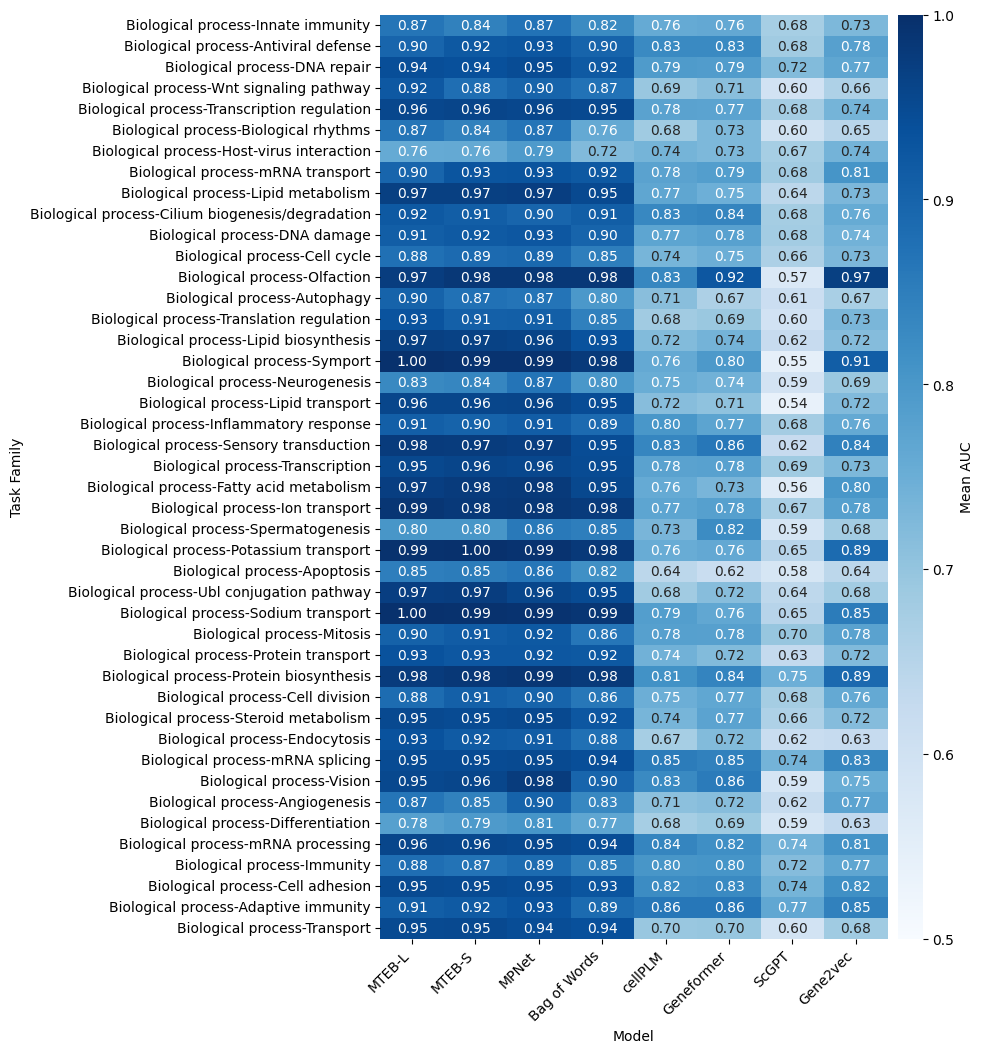

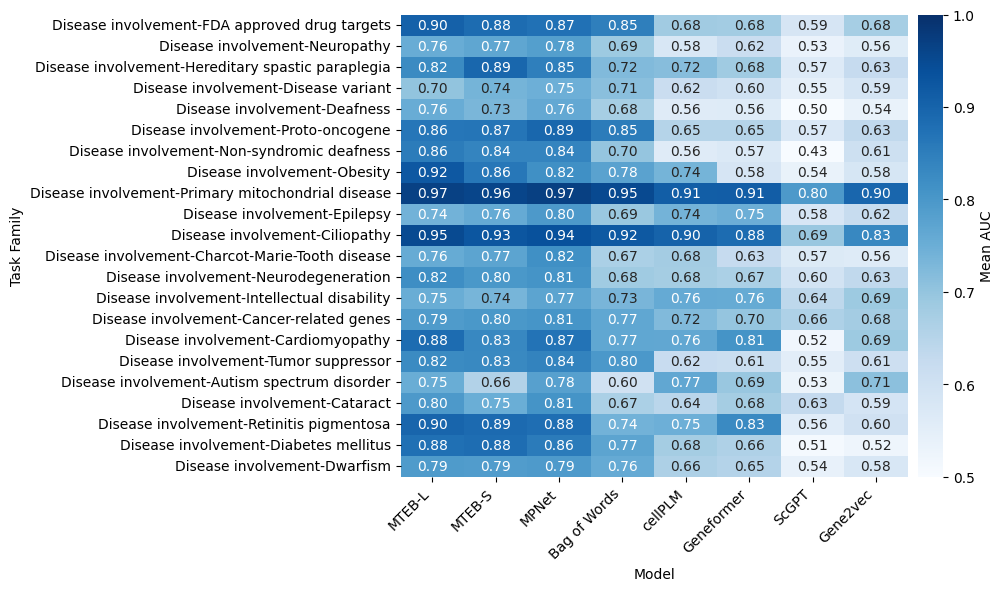

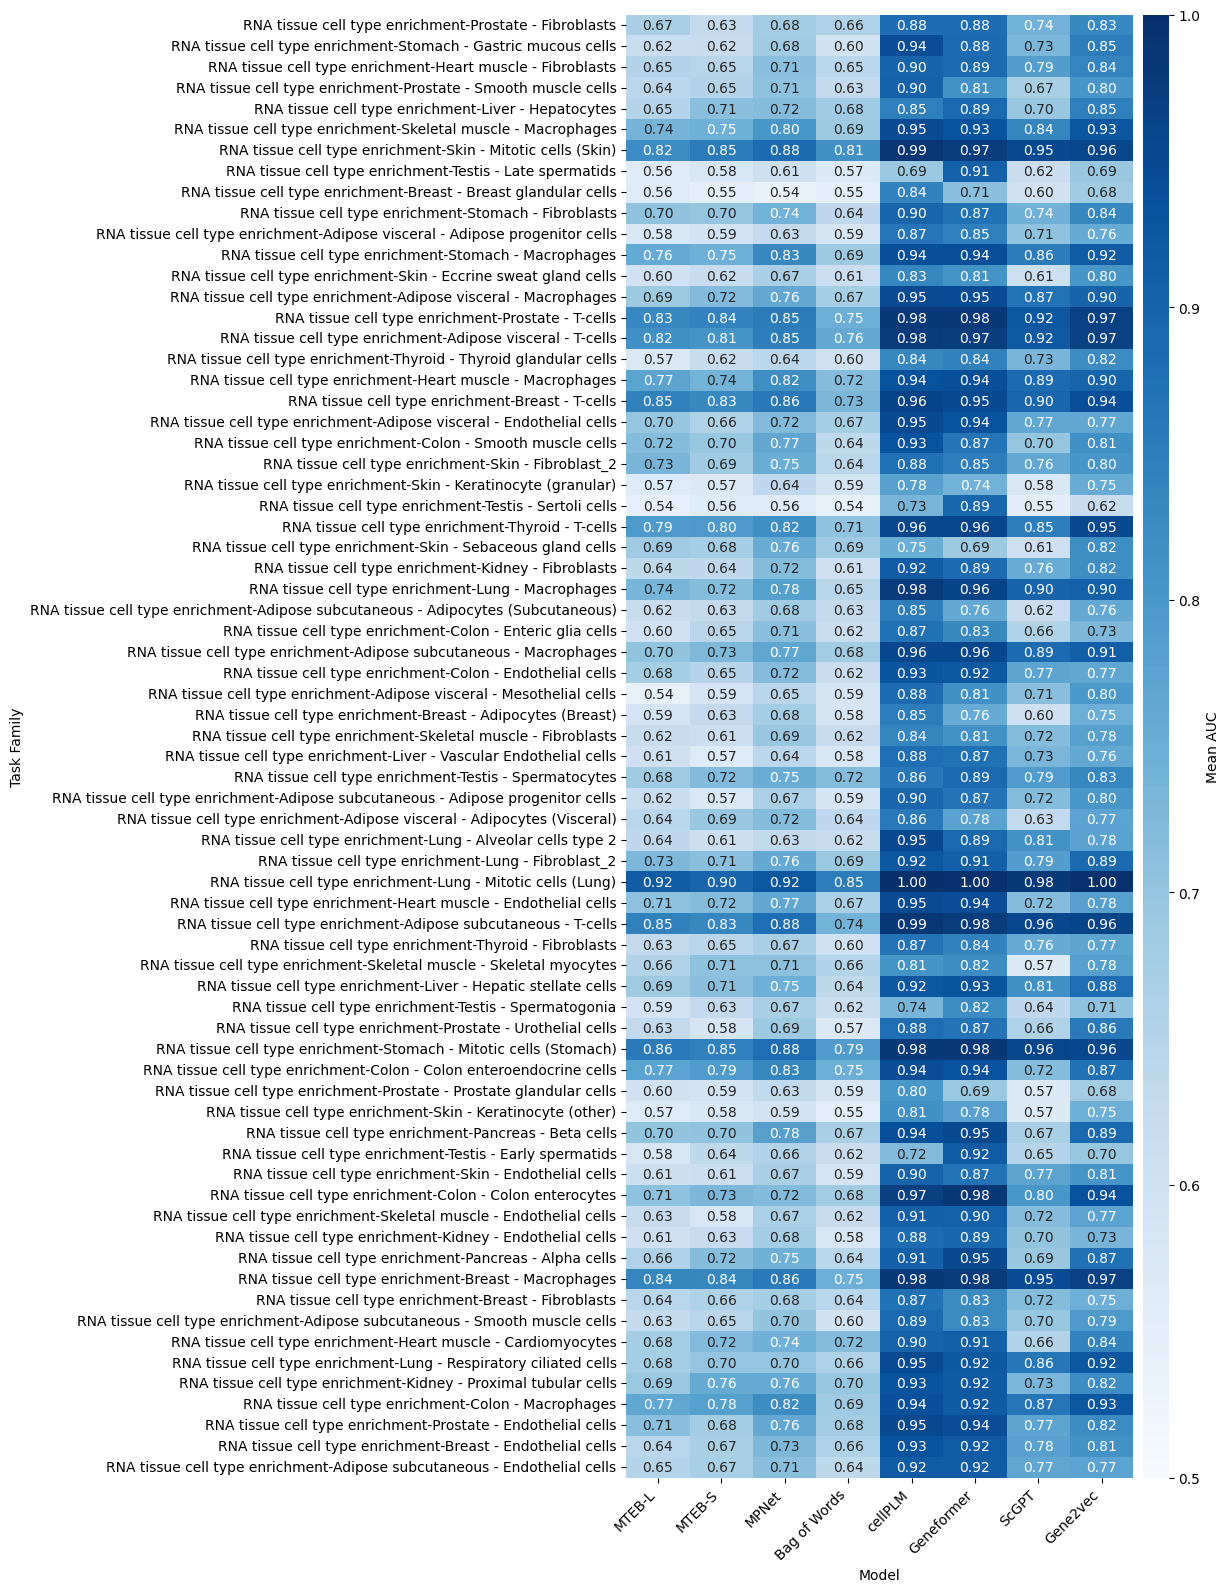

In [14]:
metric = "roc_auc"
metric_label = "Mean AUC"
derived_df["task_subtask"] = derived_df["task_name"] + "-" + derived_df["sub_task"]
for task in derived_df["task_name"].unique():
    out_file_name = task + "_derived.pdf"
    task_df = derived_df[derived_df["task_name"] == task]
    total_tasks = task_df.shape[0]
    y = 19
    if total_tasks < 10000 and total_tasks > 8000:
        y = 12
    elif total_tasks < 8000:
        y = 6
    plot_heatmap(
        data=task_df,
        row_index="task_subtask",
        metric=metric,
        metric_label=metric_label,
        metric_limits=[0.5, 1],
        agg_function="mean",
        row_order=family_order,
        col_order=model_order,
        figure_size=(7, y),
        out_file_name=out_file_name,
        annotation_function=None,
        save=True,
        task_to_family_dict_for_sorting=None,
    )

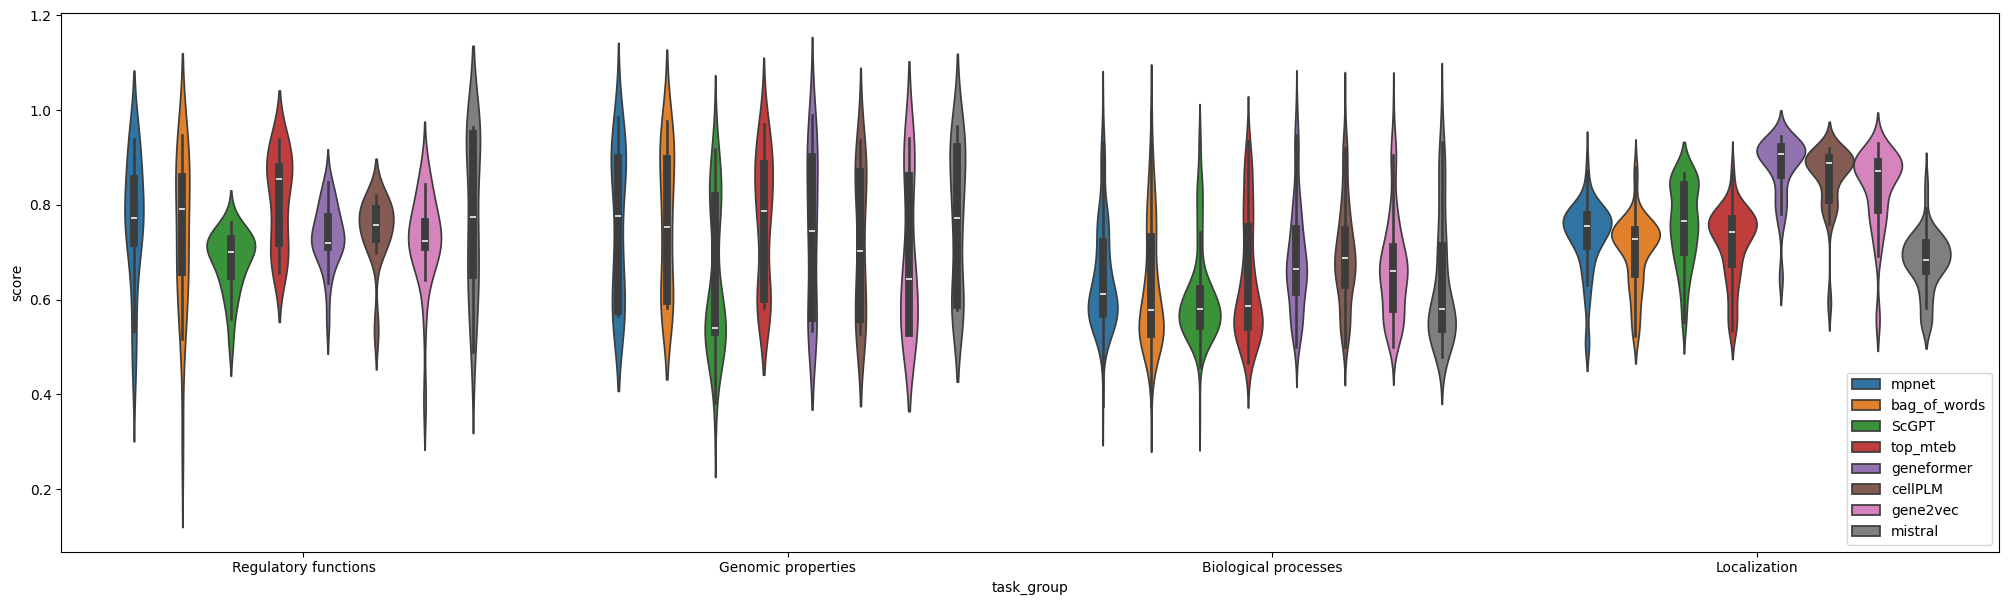

In [15]:
f, ax = plt.subplots(1, 1, figsize=[25, 7])
ax = sns.violinplot(
    data=results_df.loc[results_df["metric"] == metric, :],
    x="task_group",
    hue="model_name",
    y="score",
    ax=ax,
)
ax.legend(loc="best")

<Axes: xlabel='task_group', ylabel='score'>

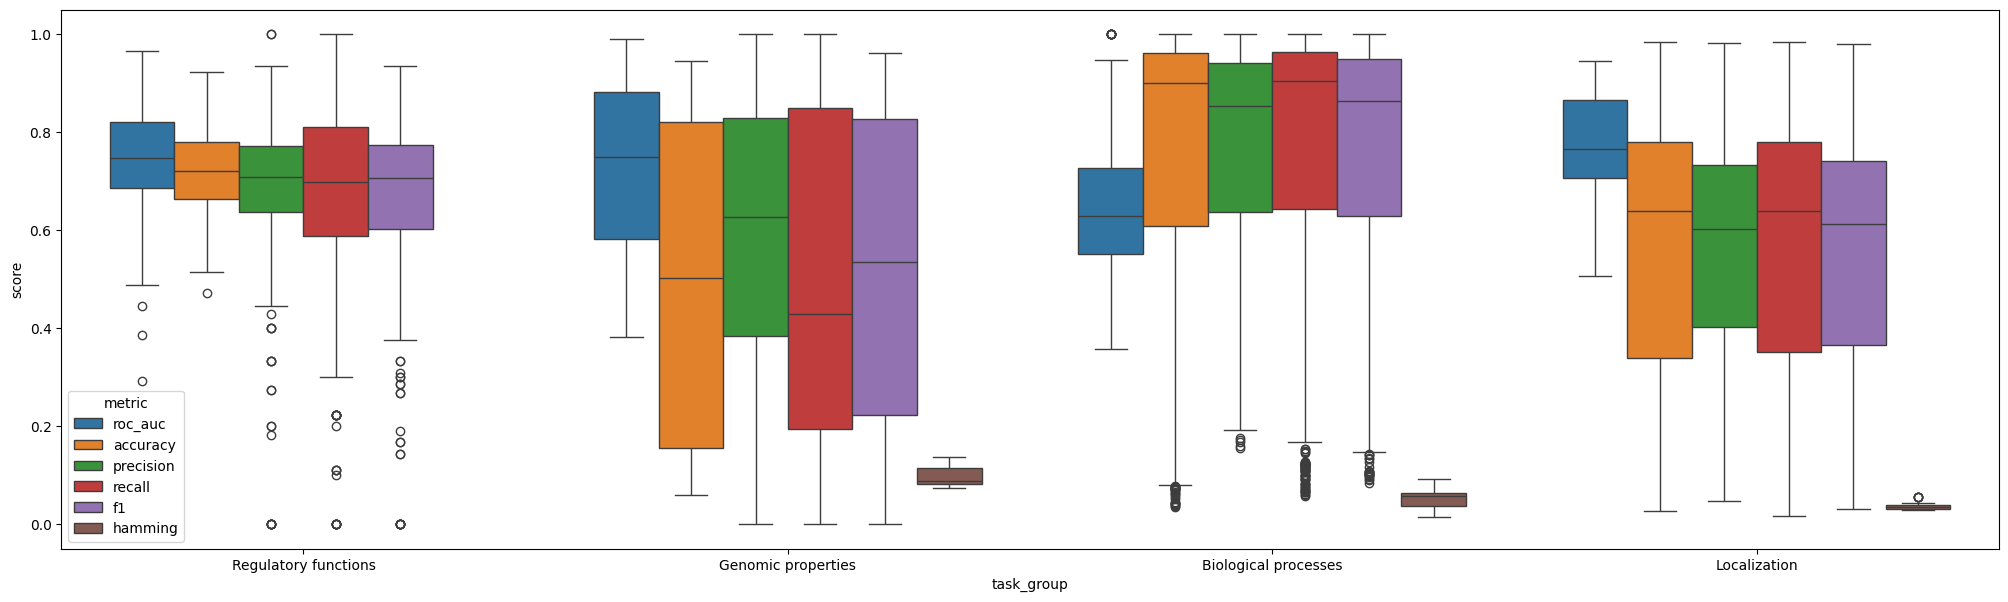

In [16]:
f, ax = plt.subplots(1, 1, figsize=[25, 7])
sns.boxplot(data=results_df, hue="metric", x="task_group", y="score", ax=ax)